In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/test.csv


# Kannada-MNIST Neural Networks and Deep Learning

## 1.0 Study purpose

Mine Kannada-MNIST data using deep neural networks for deep learning, illustrate how deep learning is the appropriate technique for the application, and make recommendations regarding the selection of parameters for neural networks.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import tensorflow as tf

In [6]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from keras.datasets import mnist, fashion_mnist, cifar100
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.constraints import max_norm
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from subprocess import check_output

#### 2.1.2 Suppress warnings


In [7]:
warnings.filterwarnings('ignore')

#### 2.1.3 Data ingestion

In [8]:
df = pd.read_csv("/kaggle/input/Kannada-MNIST/train.csv")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 359.3 MB


In [10]:
train_images = df.iloc[:, 1:].values
train_labels = df.iloc[:, 0].values

In [11]:
train_images = train_images.astype('float32')

In [14]:
train_images.shape

(60000, 784)

In [15]:
train_images_reshaped = train_images.reshape(-1, 28, 28)

In [16]:
train_images_reshaped.shape

(60000, 28, 28)

In [13]:
train_labels.shape

(60000,)

#### 2.1.4 Train test split

In [17]:
train_X = train_images_reshaped[:50000]
train_y = train_labels[:50000]

test_X = train_images_reshaped[50000:]
test_y = train_labels[50000:]

In [18]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (50000, 28, 28)
Y_train: (50000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


### 2.2 Data quality

#### 2.2.1 Training data sample images

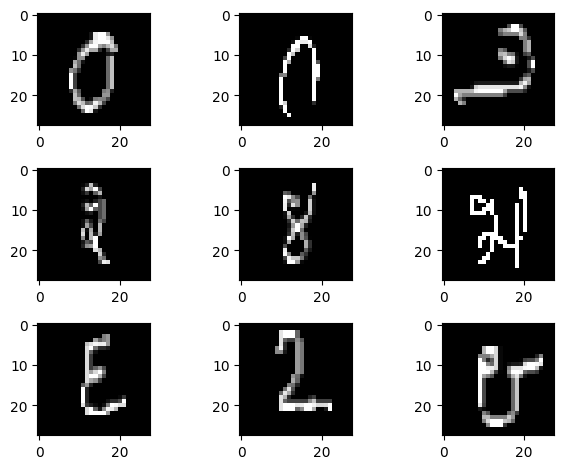

In [19]:
for i in range(9):  
    pyplot.subplot(3, 3, i + 1)
    pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
    
pyplot.tight_layout()
pyplot.show()

#### 2.2.2 Training label data counts

In [20]:
unique, counts = np.unique(train_y, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

Train labels:  {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


#### 2.2.3 Testing label data counts

In [21]:
unique, counts = np.unique(test_y, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))


Test labels:  {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


#### 2.2.4 Label descriptions

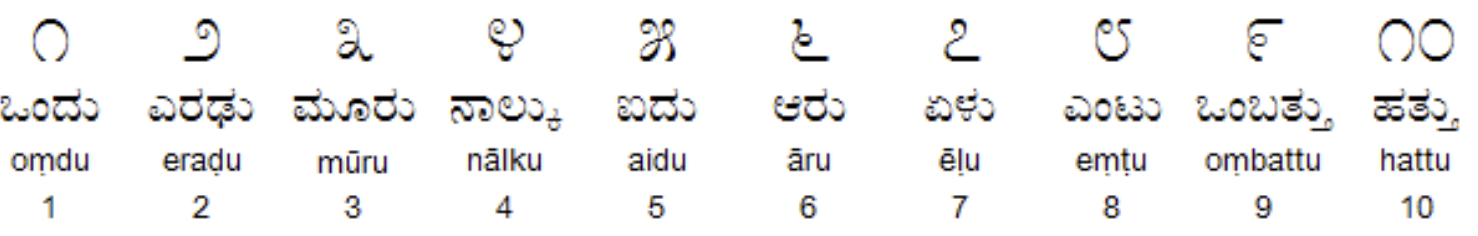

## 3.0 Data preprocessing

### 3.1 Compute the number of labels

In [22]:
num_labels = len(np.unique(train_y))
num_labels

10

### 3.2 Encode output data

In [23]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

### 3.3 Image dimensions

In [24]:
image_size = train_X.shape[1]
input_size = image_size * image_size
input_size

784

In [25]:
train_X = np.expand_dims(train_X, axis=-1)

### 3.4 Number of classes

In [33]:
num_classes = test_y.shape[1]

### 3.5 Resize and normalize data

#### 3.5.1 Training data

In [26]:
train_X1 = np.reshape(train_X, [-1, input_size])
train_X1 = train_X1.astype('float32') / 255
train_X = train_X.astype('float32') / 255

In [27]:
print('X1_train: ' + str(train_X1.shape))
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))

X1_train: (50000, 784)
X_train: (50000, 28, 28, 1)
Y_train: (50000, 10)


#### 3.5.2 Test data

In [28]:
test_X1 = np.reshape(test_X, [-1, input_size])
test_X1 = test_X1.astype('float32') / 255
test_X = test_X.astype('float32') / 255

In [29]:
print('X1_test:  '  + str(test_X1.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X1_test:  (10000, 784)
X_test:  (10000, 28, 28)
Y_test:  (10000, 10)


## 4.0 Modeling

### 4.1 Batch size for neural network model

In [30]:
batch_size = 128
input_dim = 784
epochs = 20

### 4.2 Configure the neural network model

In [35]:
def build_mlp(input_dim, num_classes, dropout_rates=[0.5, 0.3, 0.2]):
    model = Sequential()
    model.add(Dense(512, input_shape=(input_dim,), activation='relu', kernel_constraint=max_norm(3)))
    model.add(Dropout(dropout_rates[0]))
    model.add(Dense(256, activation='relu', kernel_constraint=max_norm(3)))
    model.add(Dropout(dropout_rates[1]))
    model.add(Dense(128, activation='relu', kernel_constraint=max_norm(3)))
    model.add(Dropout(dropout_rates[2]))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [36]:
model = build_mlp(input_dim=input_dim, num_classes=num_classes)

In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

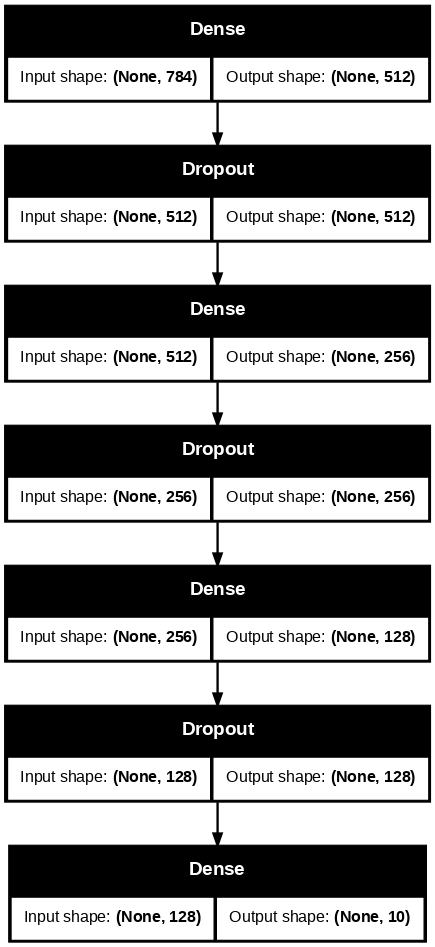

In [39]:
plot_model(model, to_file='mlp-kannada-mnist-deep.png', show_shapes=True, dpi=84)

### 4.3 Compile the neural network model

In [40]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

### 4.4 Fit the neural network model

In [41]:
history = model.fit(train_X1, train_y, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7830 - loss: 0.6807 - val_accuracy: 0.9726 - val_loss: 0.0728
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9621 - loss: 0.1265 - val_accuracy: 0.9803 - val_loss: 0.0572
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9733 - loss: 0.0867 - val_accuracy: 0.9811 - val_loss: 0.0582
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9783 - loss: 0.0706 - val_accuracy: 0.9856 - val_loss: 0.0492
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9834 - loss: 0.0560 - val_accuracy: 0.9840 - val_loss: 0.0500
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9863 - loss: 0.0452 - val_accuracy: 0.9875 - val_loss: 0.0399
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9867 - loss: 0.0401 - val_accuracy: 0.9850 - val_loss: 0.0490
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9887 - loss: 0.0345 - val_accu

## 5.0 Evaluation

In [42]:
loss, acc = model.evaluate(test_X1, test_y, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9872 - loss: 0.0551

Test accuracy: 98.7%


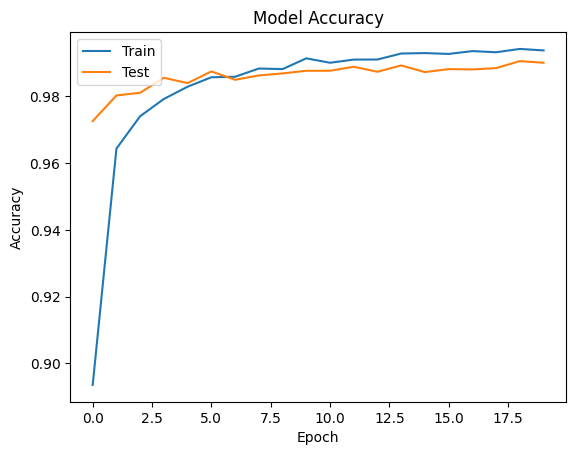

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

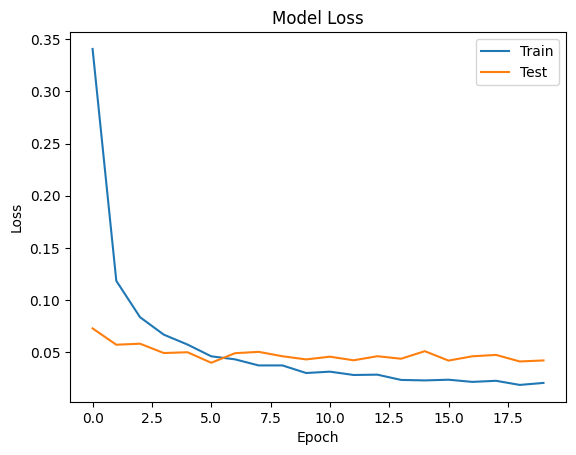

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'],loc='upper right')
plt.show()

## 6.0 Deployment

In [49]:
Xsubmission_df = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

In [50]:
X_submission_test = Xsubmission_df.drop(columns=['id']).values

In [51]:
X_submission_test_flat = X_submission_test.reshape(-1, 784)

In [52]:
X_submission_test_flat = X_submission_test_flat.astype('float32') / 255

In [53]:
predictions = model.predict(X_submission_test_flat)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [54]:
submission_df = pd.DataFrame(data={
    "id": Xsubmission_df['id'],
    "label": np.argmax(predictions, axis=1)
})

In [ ]:
submission_df.to_csv('submission.csv', index=False)